In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3","/gpu:4"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-24 18:15:50.538251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 18:15:50.551198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:15:50.564355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:15:50.568182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 18:15:50.579305: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-10-24 18:15:54.064773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0
2024-10-24 18:15:54.066279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-10-24 18:15:54.067599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random

class ImageDataProcessor:
    def __init__(self, file_path, probability_threshold=0.5):
        self.file_path = file_path
        self.probability_threshold = probability_threshold
        self.images = None
        self.centers = None
        self.train_images = None
        self.val_images = None
        self.train_centers = None
        self.val_centers = None
        self.max_x = None
        self.max_y = None

    def load_data(self):
        # Load the data from the HDF5 file
        with h5py.File(self.file_path, 'r') as hdf5_file:
            self.images = hdf5_file['images'][:]
            self.centers = hdf5_file['centers_training'][:]
        return self.images, self.centers

    def normalize_data(self):
        # Normalize image data (0 to 1 range)
        self.images = self.images.astype(np.float32) / 255.0

        # Extract only the (x, y) coordinates
        x_coords = self.centers[:, :, 1]
        y_coords = self.centers[:, :, 2]
        
        # Get the maximum values for x and y coordinates
        self.max_x = np.max(x_coords)
        self.max_y = np.max(y_coords)
        
        # Normalize center coordinates (x, y) using max_x and max_y
        self.centers[:, :, 1] = x_coords / self.max_x  # Normalize x-coordinate
        self.centers[:, :, 2] = y_coords / self.max_y  # Normalize y-coordinate
        
        # Slice off the first column (probabilities) to keep only (x, y)
        self.centers = self.centers[:, :, 1:]

        # Add a new dimension so the shape is (n, 1, 5, 2)
        self.centers = np.expand_dims(self.centers, axis=1)

        print(f"Data normalized and centers reshaped to: {self.centers.shape}")
        return self.images, self.centers

    def split_data(self, test_size=0.2, random_state=42):
        # Split the data into training and validation sets
        self.train_images, self.val_images, self.train_centers, self.val_centers = train_test_split(
            self.images, self.centers, test_size=test_size, random_state=random_state
        )
        return self.train_images, self.val_images, self.train_centers, self.val_centers
    
    def prepare_tf_datasets(self, batch_size=1000, buffer_size=8000):
        # Create TensorFlow datasets from the training and validation data
        train_dataset = tf.data.Dataset.from_tensor_slices((self.train_images, self.train_centers))
        val_dataset = tf.data.Dataset.from_tensor_slices((self.val_images, self.val_centers))
        
        # Shuffle and batch the datasets
        train_dataset = train_dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True).batch(batch_size)
        val_dataset = val_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
        
        return train_dataset, val_dataset
    
    def plot_transposed_images_with_midpoints(self, dataset, image_indices=[0, 1, 2, 3]):
        # Plot images from the dataset with their corresponding midpoints
        for images, midpoints in dataset.take(1):  # Take the first batch from the dataset
            fig, axes = plt.subplots(1, len(image_indices), figsize=(16, 4))
            
            for i, ax in enumerate(axes):
                idx = image_indices[i]
                img = images[idx].numpy()
                midpoints_for_image = midpoints[idx].numpy()
                
                ax.imshow(img, cmap='gray')
                
                # Plot all midpoints for the image, rescale using max_x and max_y
                for midpoint in midpoints_for_image[0]:  # Access the added dimension
                    x = midpoint[0] * self.max_x  # Rescale x-coordinate
                    y = midpoint[1] * self.max_y  # Rescale y-coordinate
                    ax.scatter(x, y, c='red', marker='x', label='Midpoint')
                
                ax.set_title(f'Image {i + 1}')
                ax.axis('off')

            plt.tight_layout()
            plt.show()

In [4]:

# Create an instance of the class and test it with the provided data
processor = ImageDataProcessor(file_path='/home/da886/Final Electron counting project/Images and Labels/12KFixed_Mixed_5_32by32_95indexNoNoise.h5')


In [5]:


images, centers = processor.load_data()
normalized_images, normalized_centers = processor.normalize_data()
train_images, val_images, train_centers, val_centers = processor.split_data()

# Prepare TensorFlow datasets
train_dataset, val_dataset = processor.prepare_tf_datasets(batch_size=1000)


Data normalized and centers reshaped to: (12000, 1, 5, 2)


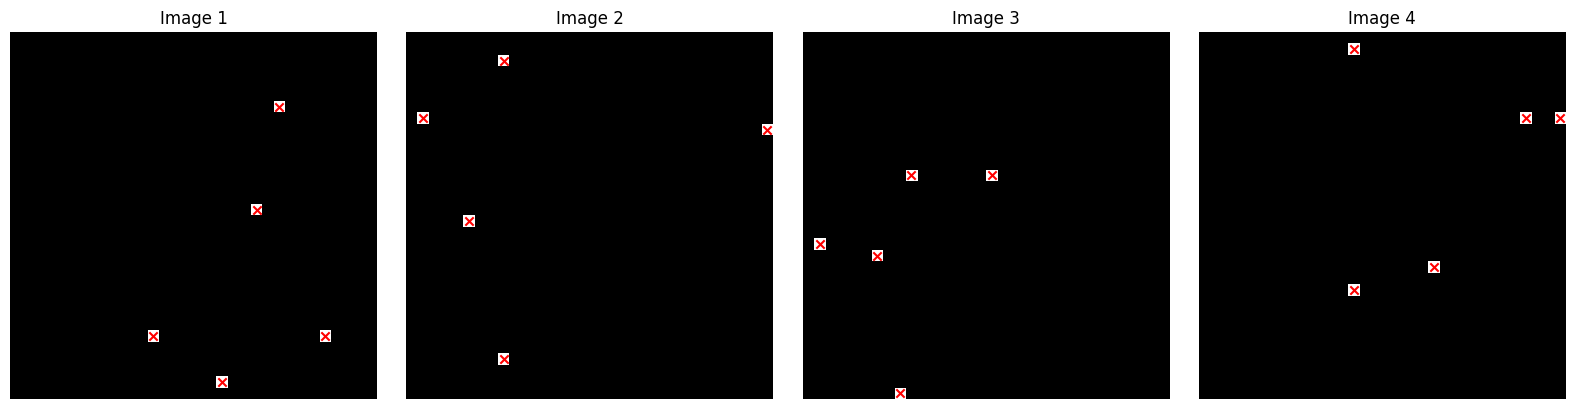

2024-10-24 18:16:09.056603: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:

# Plot transposed images with midpoints
processor.plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])


my NEW model

In [7]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=5, num_coordinates=2, learning_rate=1e-4, weights_path=None, l1_reg=0.001, l2_reg=0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)
        
        
    
        x_input = layers.Input(shape=self.input_shape)
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='linear', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [8]:
train_centers.shape

(9600, 1, 5, 2)

In [9]:
np.min(train_images), np.max(train_images), np.min(train_centers), np.max(train_centers)

(0.0, 1.0, 0.032258064, 1.0)

In [10]:
np.max(centers)

1.0

In [11]:
centers

array([[[1.        , 0.61290324, 0.32258064],
        [1.        , 0.06451613, 0.5483871 ],
        [1.        , 0.9354839 , 0.16129032],
        [1.        , 0.61290324, 0.61290324],
        [1.        , 0.06451613, 0.19354838]],

       [[1.        , 0.7741935 , 0.38709676],
        [1.        , 0.4516129 , 0.9354839 ],
        [1.        , 0.67741936, 0.48387095],
        [1.        , 0.3548387 , 0.4516129 ],
        [1.        , 0.03225806, 0.516129  ]],

       [[1.        , 0.83870965, 0.16129032],
        [1.        , 0.67741936, 0.2580645 ],
        [1.        , 0.38709676, 0.38709676],
        [1.        , 0.83870965, 0.03225806],
        [1.        , 0.29032257, 0.7419355 ]],

       ...,

       [[1.        , 0.3548387 , 0.2580645 ],
        [1.        , 0.4516129 , 0.516129  ],
        [1.        , 0.83870965, 0.12903225],
        [1.        , 0.06451613, 0.9032258 ],
        [1.        , 0.32258064, 0.16129032]],

       [[1.        , 0.8064516 , 0.16129032],
        [1.  

In [9]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=5e-6
)


In [10]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    model_builder = ModelBuilder()

    model_builder.build_model()

    model_builder.model.summary()

    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
  




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 10)             │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 5, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,235,210 (31.41 MB)

 Trainable params: 8,234,698 (31.41 MB)

 Non-trainable params: 512 (2.00 KB)

In [11]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=100,
    callbacks_list=[lr_scheduler]
)


Epoch 1/100


2024-10-24 18:16:23.532872: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-24 18:16:33.990932: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-24 18:16:34.000287: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729793794.071920 1549437 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793794.074873 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793794.116855 1549437 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793794.117011 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793794.117276 1549437 gpu_timer.cc:11

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3364

W0000 00:00:1729793803.655714 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.656173 1549415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.656826 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.657486 1549415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.663759 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.664969 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.665880 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.666499 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793803.668363 1549396 gp

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2676

2024-10-24 18:16:44.260007: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-24 18:16:44.260279: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
W0000 00:00:1729793804.289102 1549395 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793804.289677 1549395 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793804.289687 1549428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793804.290177 1549395 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793804.290355 1549428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 0.2593

W0000 00:00:1729793808.256982 1549440 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.260440 1549440 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.260645 1549430 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.261064 1549440 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.261465 1549430 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.261869 1549440 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.262330 1549430 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.262670 1549440 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793808.263140 1549430 gp

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.2524 - val_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 2/100


W0000 00:00:1729793816.281243 1549405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.282173 1549405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.283292 1549405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.284484 1549405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.290079 1549405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.290792 1549395 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.291050 1549405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.292196 1549395 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793816.292343 1549405 gp

 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - loss: 0.1005

2024-10-24 18:16:56.566850: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0865 - val_loss: 0.3363 - learning_rate: 1.0000e-04
Epoch 3/100


2024-10-24 18:16:57.610383: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0740 - val_loss: 0.3356 - learning_rate: 1.0000e-04
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0718 - val_loss: 0.3326 - learning_rate: 1.0000e-04
Epoch 5/100


2024-10-24 18:17:00.332773: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0706 - val_loss: 0.3353 - learning_rate: 1.0000e-04
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0699 - val_loss: 0.3363 - learning_rate: 1.0000e-04
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0692 - val_loss: 0.3276 - learning_rate: 1.0000e-04
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0689 - val_loss: 0.3335 - learning_rate: 1.0000e-04
Epoch 9/100


2024-10-24 18:17:05.389820: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0686 - val_loss: 0.3297 - learning_rate: 1.0000e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0686 - val_loss: 0.3255 - learning_rate: 1.0000e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0678 - val_loss: 0.3285 - learning_rate: 1.0000e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0679 - val_loss: 0.3203 - learning_rate: 1.0000e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0675 - val_loss: 0.3195 - learning_rate: 1.0000e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0669 - val_loss: 0.3189 - learning_rate: 1.0000e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0674 - val_loss: 0.3146 - learning_rate: 1.0000e-04
Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0671 - val_loss: 0.3151 - learning_rate: 1.0000e-04
Epoch 17/100


2024-10-24 18:17:15.753057: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0669 - val_loss: 0.3140 - learning_rate: 1.0000e-04
Epoch 18/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0669 - val_loss: 0.3109 - learning_rate: 1.0000e-04
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0663 - val_loss: 0.3025 - learning_rate: 1.0000e-04
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0666 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0667 - val_loss: 0.2997 - learning_rate: 1.0000e-04
Epoch 22/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0666 - val_loss: 0.2890 - learning_rate: 1.0000e-04
Epoch 23/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0664 - val_loss: 0.2908 - learning_rate: 1.0000e-04
Epoch 24/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0661 - val_loss: 0.2876 - learning_rate: 1.0000e-04
Epoch 25/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0660 - val_loss: 0.2864 - 

2024-10-24 18:17:27.099283: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0656 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 27/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0658 - val_loss: 0.2793 - learning_rate: 1.0000e-04
Epoch 28/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0659 - val_loss: 0.2763 - learning_rate: 1.0000e-04
Epoch 29/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0655 - val_loss: 0.2739 - learning_rate: 1.0000e-04
Epoch 30/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0656 - val_loss: 0.2667 - learning_rate: 1.0000e-04
Epoch 31/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0654 - val_loss: 0.2622 - learning_rate: 1.0000e-04
Epoch 32/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0652 - val_loss: 0.2591 - learning_rate: 1.0000e-04
Epoch 33/100


2024-10-24 18:17:37.301359: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0654 - val_loss: 0.2566 - learning_rate: 1.0000e-04
Epoch 34/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0654 - val_loss: 0.2536 - learning_rate: 1.0000e-04
Epoch 35/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0649 - val_loss: 0.2470 - learning_rate: 1.0000e-04
Epoch 36/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0651 - val_loss: 0.2503 - learning_rate: 1.0000e-04
Epoch 37/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0646 - val_loss: 0.2452 - learning_rate: 1.0000e-04
Epoch 38/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0643 - val_loss: 0.2361 - learning_rate: 1.0000e-04
Epoch 39/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0641 - val_loss: 0.2319 - learning_rate: 1.0000e-04
Epoch 40/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0638 - val_loss: 0.2275 - learning_rate: 1.0000e-04
Epoch 41/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0635 - val_loss: 0.2227 

2024-10-24 18:17:57.891567: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0612 - val_loss: 0.1937 - learning_rate: 1.0000e-04
Epoch 50/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0606 - val_loss: 0.1922 - learning_rate: 1.0000e-04
Epoch 51/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0598 - val_loss: 0.1771 - learning_rate: 1.0000e-04
Epoch 52/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0592 - val_loss: 0.1815 - learning_rate: 1.0000e-04
Epoch 53/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0579 - val_loss: 0.1735 - learning_rate: 1.0000e-04
Epoch 54/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0580 - val_loss: 0.1746 - learning_rate: 1.0000e-04
Epoch 55/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0572 - val_loss: 0.1726 - learning_rate: 1.0000e-04
Epoch 56/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0565 - val_loss: 0.1587 - learning_rate: 1.0000e-04
Epoch 57/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0557 - val_loss: 0.1616 -

2024-10-24 18:18:18.537016: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0460 - val_loss: 0.1358 - learning_rate: 1.0000e-04
Epoch 66/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0445 - val_loss: 0.1333 - learning_rate: 1.0000e-04
Epoch 67/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0440 - val_loss: 0.1299 - learning_rate: 1.0000e-04
Epoch 68/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0423 - val_loss: 0.1260 - learning_rate: 1.0000e-04
Epoch 69/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 0.0404 - val_loss: 0.1380 - learning_rate: 1.0000e-04
Epoch 70/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0386 - val_loss: 0.1358 - learning_rate: 1.0000e-04
Epoch 71/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0373 - val_loss: 0.1386 - learning_rate: 1.0000e-04
Epoch 72/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0359 - val_loss: 0.1290 - learning_rate: 1.0000e-04
Epoch 73/100


2024-10-24 18:18:28.626256: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0347 - val_loss: 0.1175 - learning_rate: 1.0000e-04
Epoch 74/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0327 - val_loss: 0.1184 - learning_rate: 1.0000e-04
Epoch 75/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0305 - val_loss: 0.1162 - learning_rate: 1.0000e-04
Epoch 76/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0296 - val_loss: 0.1454 - learning_rate: 1.0000e-04
Epoch 77/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0288 - val_loss: 0.1221 - learning_rate: 1.0000e-04
Epoch 78/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0264 - val_loss: 0.1143 - learning_rate: 1.0000e-04
Epoch 79/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0252 - val_loss: 0.1093 - learning_rate: 1.0000e-04
Epoch 80/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0237 - val_loss: 0.1222 - learning_rate: 1.0000e-04
Epoch 81/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0220 - val_loss: 0.1190 -

2024-10-24 18:18:59.349842: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0080 - val_loss: 0.1032 - learning_rate: 1.0000e-04
Epoch 97/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0073 - val_loss: 0.1019 - learning_rate: 1.0000e-04
Epoch 98/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0069 - val_loss: 0.1038 - learning_rate: 1.0000e-04
Epoch 99/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0068 - val_loss: 0.1011 - learning_rate: 1.0000e-04
Epoch 100/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0061 - val_loss: 0.1001 - learning_rate: 1.0000e-04


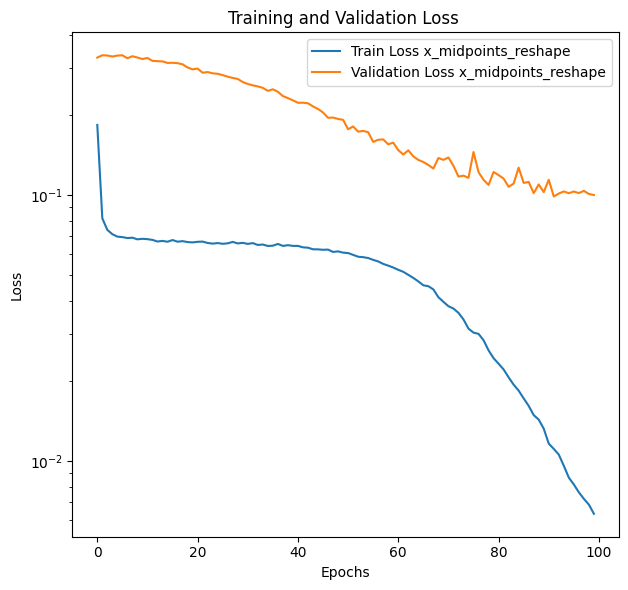

In [12]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
# model_builder.model.save("/home/da886/Analysis/13KFixed_Mixed_5_32by32_95indexFor19KernelNoNoise.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Define the function for visualizing midpoints
# def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - title: The title of the plot.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title(title)

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Create the validation dataset
# # val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# # val_dataset = val_dataset.batch(800)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# # inputs,targets = next(iter(train_dataset))
# # outputs = model_builder.model.predict(inputs)
# # # Initialize lists to collect the data
# all_images = []
# all_true_midpoints = []
# all_pred_midpoints = []

# # # Loop through each batch in the validation dataset, predict, and collect results
# # for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
#     print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
#     # Get the model predictions
#     predictions =model_builder.model.predict(data_batch)

#     # Extend the lists to store data from each batch
#     all_images.extend(data_batch.numpy())  # Store all images
#     all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
#     all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# # Convert lists to arrays for easier indexing
# all_images = np.array(all_images)
# all_true_midpoints = np.array(all_true_midpoints)
# all_pred_midpoints = np.array(all_pred_midpoints)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints_with_gt(image, true_midpoints, pred_midpoints, max_x, max_y, title="Predicted vs GT Midpoints"):
    """
    Visualizes ground truth and predicted midpoints on an image and draws lines to connect them.

    Parameters:
    - image: A 3D tensor representing the image.
    - true_midpoints: A 2D tensor representing the ground truth midpoint coordinates (x, y).
    - pred_midpoints: A 2D tensor representing the predicted midpoint coordinates (x, y).
    - max_x: Maximum value for x-coordinate used during normalization.
    - max_y: Maximum value for y-coordinate used during normalization.
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints and lines).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image

    # Ensure that midpoints are in the shape (num_points, 2) for both true and predicted midpoints
    true_midpoints_np = np.reshape(true_midpoints, (-1, 2))
    pred_midpoints_np = np.reshape(pred_midpoints, (-1, 2))

    # Undo the normalization by multiplying by max_x and max_y
    true_midpoints_np[:, 0] *= max_x  # Rescale x-coordinate for GT
    true_midpoints_np[:, 1] *= max_y  # Rescale y-coordinate for GT
    pred_midpoints_np[:, 0] *= max_x  # Rescale x-coordinate for predictions
    pred_midpoints_np[:, 1] *= max_y  # Rescale y-coordinate for predictions

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np, cmap='gray')
    plt.title(title)

    # Plot both ground truth and predicted midpoints
    for i, ((gt_x, gt_y), (pred_x, pred_y)) in enumerate(zip(true_midpoints_np, pred_midpoints_np)):
        if gt_x >= 0 and gt_y >= 0:  # Only plot if the GT point is valid
            plt.scatter(gt_x, gt_y, color='blue', label='Ground Truth' if i == 0 else "", s=30)
            plt.scatter(pred_x, pred_y, color='red', label='Prediction' if i == 0 else "", s=30)

            # Draw a line connecting the GT and predicted points
            plt.plot([gt_x, pred_x], [gt_y, pred_y], color='green', linewidth=1)

    # Add legend only once
    plt.legend()
    plt.show()

# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_centers))
train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the training dataset, predict, and collect results
for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)


2024-10-24 18:19:47.916421: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1729793988.210160 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.210934 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.211296 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.211618 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.211904 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.212234 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.212238 1549427 gpu_timer

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 


W0000 00:00:1729793988.613756 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.615230 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.624495 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.624797 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.625084 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.625391 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.625699 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.626003 1549396 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729793988.626309 1549396 gp

Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


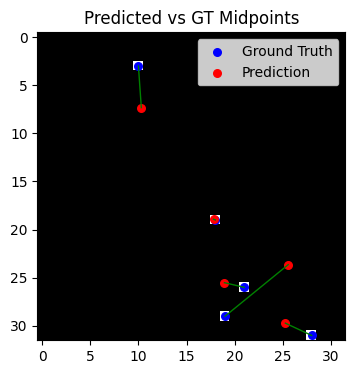

In [30]:

# Example: Select a random image and visualize it
index_to_visualize = np.random.randint(0, len(all_images))

# Retrieve max_x and max_y from your processor object (replace 'processor' with your actual instance)
max_x = processor.max_x
max_y = processor.max_y

# Visualize the results for the selected sample
visualize_midpoints_with_gt(
    all_images[index_to_visualize], 
    all_true_midpoints[index_to_visualize], 
    all_pred_midpoints[index_to_visualize], 
    max_x=max_x, 
    max_y=max_y
)


In [31]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 32, 32), (9600, 1, 5, 2), (9600, 1, 5, 2))

In [44]:
np.min(all_pred_midpoints),np.max(all_pred_midpoints)

(0.008167226, 30.561823)

In [46]:
np.min(all_true_midpoints),np.max(all_true_midpoints)

(0.032258064, 31.0)

In [40]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 31.0)

In [41]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[ 4.2590027,  3.908059 ],
         [27.263153 ,  4.3831873],
         [ 5.8743353,  6.6574388],
         [14.020337 ,  8.760142 ],
         [ 4.1754484, 10.7192545],
         [ 4.123699 , 11.2907295],
         [22.326601 , 11.401616 ],
         [ 7.203351 , 12.493043 ],
         [ 5.814977 , 12.613149 ],
         [21.202332 , 14.556165 ],
         [ 8.0557995, 17.444569 ],
         [ 8.055367 , 18.544151 ],
         [ 5.2744675, 26.596989 ]]], dtype=float32),
 array([[[ 4.,  3.],
         [28.,  6.],
         [ 6.,  7.],
         [14.,  9.],
         [ 4., 10.],
         [ 4., 10.],
         [22., 11.],
         [ 7., 12.],
         [ 6., 14.],
         [21., 15.],
         [ 8., 17.],
         [ 8., 18.],
         [ 5., 28.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

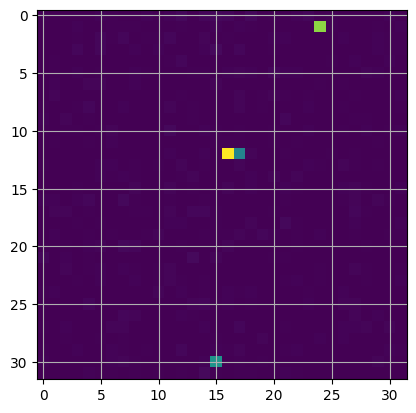

In [44]:
plt.imshow(images[2],)
plt.grid(True)

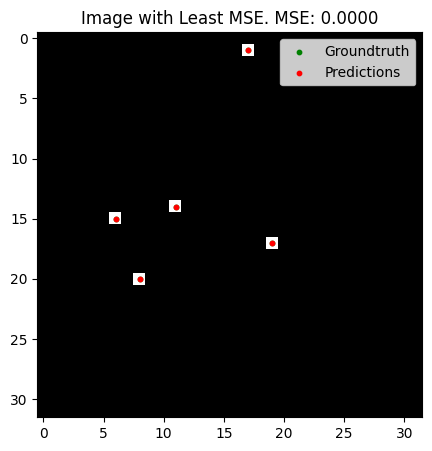

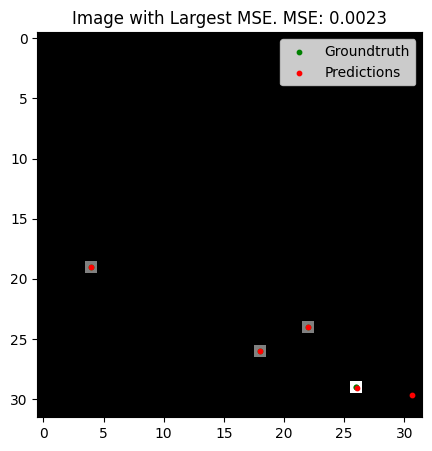

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266